# Next Pitch Prediction using GRUs

The first series of tests will be carried out using basic GRUs. GRUs are a type of RNN that are simpler than LSTMs and are often used when the data is not too complex. The idea is to use the GRU to predict the next pitch in a sequence of pitches

## Data loading and sequencing

In [1]:
import os
import tensorflow as tf
import keras_tuner

os.chdir('../..')
tf.keras.utils.set_random_seed(42)

The first step is to load the pitch data and sequence it into a format that can be used to train the LSTM. For this, the preprocessing utils developed earlier will be used.

It is also necessary to split the data into training, validation and test sets. A 60-20-20 split will be done using Scikit Learn.

In [2]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=54)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

## Develop a model that does better than the baseline

The first step in the process is to develop a basic model that beats the baseline. This model will be a ensemble of LSTMs with 1 hidden layer with 128 units.

To streamline the process, two new functions will be developed:
- `build_network`: which builds a single LSTM network with the specified parameters and compiles it.
- `build_model`: which builds an ensemble of LSTM networks. This function will be used by Keras Tuner to optimize the hyperparameters of the model.

In [3]:
def build_network(input_layer, num_targets, name='', num_hidden_units=128, num_hidden_layers=1, activation='tanh', recurrent_activation='sigmoid', reg=None, dropout=None):
    
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        layer_name = f"{name}_hidden_{i+1}"
        if reg:
            x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, kernel_regularizer=reg, name=layer_name)(x)
        else:
            x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, name=layer_name)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)
    
    # Last hidden layer without return_sequences
    layer_name = f"{name}_hidden_{num_hidden_layers}"
    if reg:
        x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, kernel_regularizer=reg, name=layer_name)(x)
    else:
        x = tf.keras.layers.GRU(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, name=layer_name)(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=f'{name}_output')(x)

    return outputs

It is important to define the search space for the hyperparameters. The following hyperparameters will be optimized:

- **Number of units in the hidden layer**: This will be chosen from the values [128, 256, 512].
- **Number of hidden layers**: This will be an integer value between 1 and 3.
- **Activation function**: This will be chosen from the values ['relu', 'elu', 'tanh', 'sigmoid'].
- **Recurrent activation function**: This will be chosen from the values ['relu', 'elu', 'sigmoid', 'tanh'].

In [13]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                         num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                         activation=hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid']),
                         recurrent_activation=hp.Choice('recurrent_activation', values=['relu', 'elu', 'sigmoid', 'tanh']))
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                          num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                          activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                          recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']))
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1),
                            num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                            recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']))

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

To avoid wasting time and computational resources, we will implement early stopping with a patience of 5 epochs. Since the `EarlyStopping` callback from Tensorflow is designed for a single model, we will implement a custom callback that will monitor every model in the ensemble and freeze the weights independently if the model performance starts to degrade.

In [10]:
from utils.callbacks import FreezeOutputCallback

freeze_output_callback = FreezeOutputCallback(patience=5)

In [14]:
# Create an instance of the HyperParameters object
hp = keras_tuner.HyperParameters()

# Test the build_model function
model = build_model(hp)

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output vertical at 6 epochs.

Freezing output horizontal at 26 epochs.

Freezing output pitch at 37 epochs.

All outputs frozen. Stopping training at epoch 37.


In [15]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - horizontal_output_accuracy: 0.5005 - loss: nan - pitch_output_accuracy: 0.5155 - vertical_output_accuracy: 0.6248
Pitch Test Accuracy: 0.4925875961780548
Vertical Test Accuracy: 0.5111185908317566
Horizontal Test Accuracy: 0.6263477206230164


We can notice a considerable improvement in the model performance.

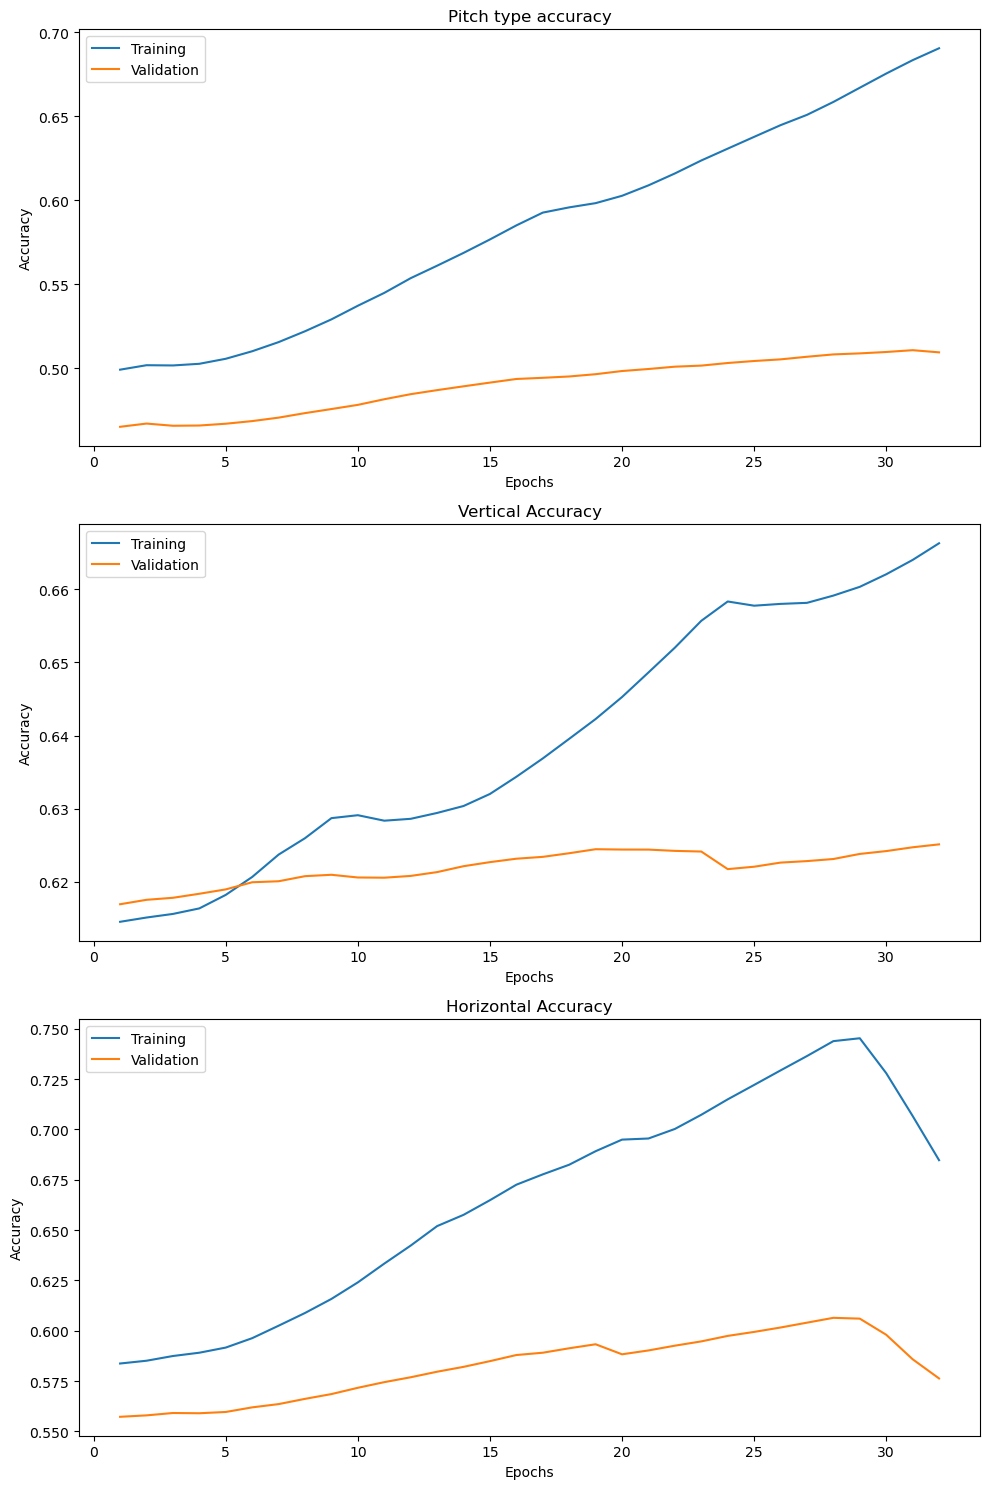

In [16]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

## Scale up

Now, it is time to scale up the model to increase its performance. For this, we will run Bayesian optimization using the `BayesianOptimization` class from the Keras Tuner library. The search space will be the one defined earlier. The optimization will be carried out for 10 iterations.

In [17]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=10,
    project_name='GRU_Ensemble'
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=100, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[freeze_output_callback],
            )

Trial 10 Complete [00h 03m 23s]
multi_objective: -1.6108490824699402

Best multi_objective So Far: -1.9858490228652954
Total elapsed time: 00h 36m 33s


In [18]:
import pandas as pd

# Get the tuner results
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Extract relevant information
results = []
for trial in tuner_results:
    trial_summary = {
        'Trial ID': trial.trial_id,
        'Hidden layers': trial.hyperparameters.values['num_hidden_layers'],
        'Hidden units': trial.hyperparameters.values['num_hidden_units'],
        'Activation': trial.hyperparameters.values['activation'],
        'Recurrent Activation': trial.hyperparameters.values['recurrent_activation'],
        'Score': trial.score,
        'Pitch Accuracy': trial.metrics.get_last_value('val_pitch_output_accuracy'),
        'Vertical Accuracy': trial.metrics.get_last_value('val_vertical_output_accuracy'),
        'Horizontal Accuracy': trial.metrics.get_last_value('val_horizontal_output_accuracy')
    }
    results.append(trial_summary)

# Create a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('lstm_search_results.csv', index=False)

# Display the results
results_df

,Trial ID,Hidden layers,Hidden units,Activation,Recurrent Activation,Score,Pitch Accuracy,Vertical Accuracy,Horizontal Accuracy
0,05,1,128,relu,sigmoid,-1.985849,0.579515,0.718329,0.688005
1,04,3,128,relu,tanh,-1.951146,0.590633,0.701146,0.659367
2,07,1,256,relu,relu,-1.768868,0.535377,0.622305,0.611186
3,01,1,256,tanh,elu,-1.739555,0.496631,0.646900,0.596024
4,03,2,256,relu,relu,-1.733154,0.502022,0.631402,0.599730
5,06,3,256,relu,relu,-1.663073,0.482817,0.616914,0.563342
6,08,3,256,tanh,elu,-1.620283,0.457547,0.610175,0.552561
7,09,1,512,sigmoid,elu,-1.610849,0.446092,0.616914,0.547844
8,00,2,256,elu,relu,-1.574461,0.454852,0.613208,0.506402
9,02,3,512,tanh,relu,-1.556267,0.409030,0.616914,0.530323


Increasing model complexity further improved performance.  Notably, models with three hidden layers achieved the highest accuracy for each output, suggesting that a deeper architecture is advantageous.

However, increased model size correlates with longer training times.  Therefore, a balance must be struck between complexity and training duration.  Consequently, the hyperparameters from Trial 04 will be used for vertical and horizontal location, and those from Trial 01 for pitch type. While the model in Trial 02 demonstrated the best overall performance, its significantly higher number of hyperparameters results in considerably longer training times.

## Regularizing the model

In [19]:
def build_model():
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=3,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='tanh')
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid')
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid')

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [20]:
model = build_model()
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=1
                            )

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - horizontal_output_accuracy: 0.4692 - loss: 3.6231 - pitch_output_accuracy: 0.3707 - vertical_output_accuracy: 0.5885 - val_horizontal_output_accuracy: 0.5239 - val_loss: 3.2343 - val_pitch_output_accuracy: 0.4107 - val_vertical_output_accuracy: 0.6169
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - horizontal_output_accuracy: 0.5381 - loss: 3.2039 - pitch_output_accuracy: 0.4335 - vertical_output_accuracy: 0.6097 - val_horizontal_output_accuracy: 0.5398 - val_loss: 3.1610 - val_pitch_output_accuracy: 0.4508 - val_vertical_output_accuracy: 0.6169
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - horizontal_output_accuracy: 0.5515 - loss: 3.1091 - pitch_output_accuracy: 0.4718 - vertical_output_accuracy: 0.6101 - val_horizontal_output_accuracy: 0.5367 - val_loss: 3.1254 - val_pitch_output_accuracy: 0.4639 - val_vertical_output_accuracy: 0.6189
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - horizontal_output_a

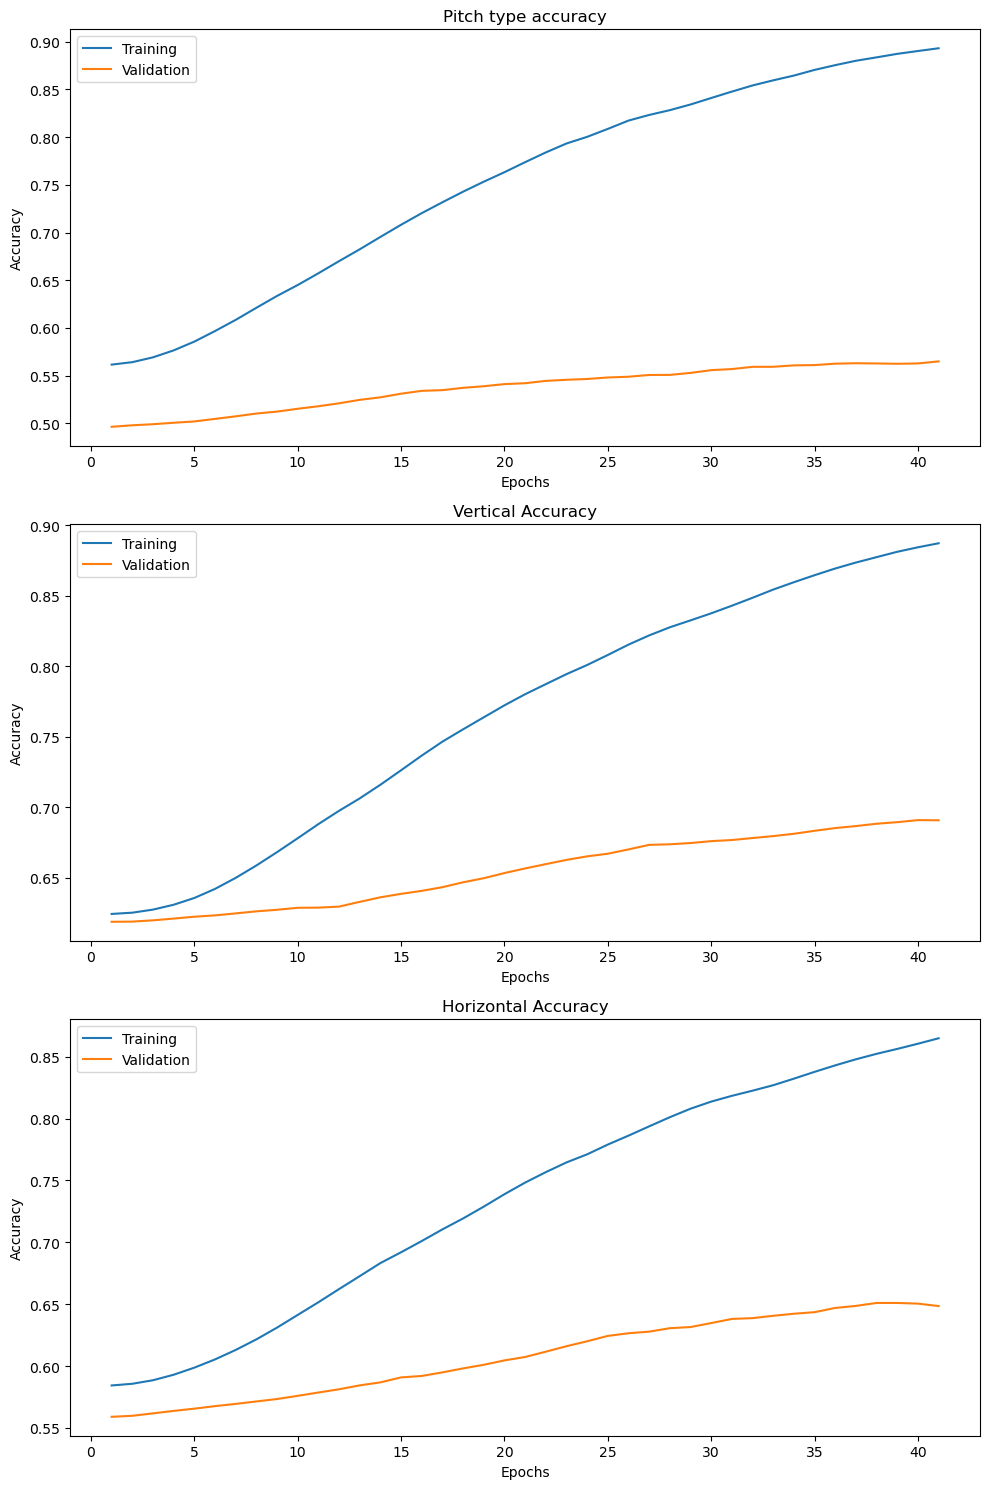

In [21]:
plot_ensemble_history(history)

We see no signs of overfitting in the location networks. However, pitch type accuracy suffers a big drop after epoch 25. Let's apply regularization to the network.

### Regularization

In [22]:
def build_model(reg):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=3,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='tanh',
                         reg=reg)
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid',
                         reg=reg)
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid',
                         reg=reg)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [23]:
regularizations = [tf.keras.regularizers.l1(0.001), tf.keras.regularizers.l2(0.001), tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)]
histories = []

for reg in regularizations:
    print("Testing with regularization:", reg)
    model = build_model(reg)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories.append(history)

Testing with regularization: <keras.src.regularizers.regularizers.L1 object at 0x000001C003F9F950>

Freezing output vertical at 6 epochs.

Freezing output horizontal at 10 epochs.

Freezing output pitch at 15 epochs.

All outputs frozen. Stopping training at epoch 15.
Testing with regularization: <keras.src.regularizers.regularizers.L2 object at 0x000001C004F805D0>

Freezing output vertical at 11 epochs.

Freezing output pitch at 28 epochs.

Freezing output horizontal at 44 epochs.

All outputs frozen. Stopping training at epoch 44.
Testing with regularization: <keras.src.regularizers.regularizers.L1L2 object at 0x000001C003F89ED0>

Freezing output vertical at 6 epochs.

Freezing output horizontal at 8 epochs.

Freezing output pitch at 16 epochs.

All outputs frozen. Stopping training at epoch 16.


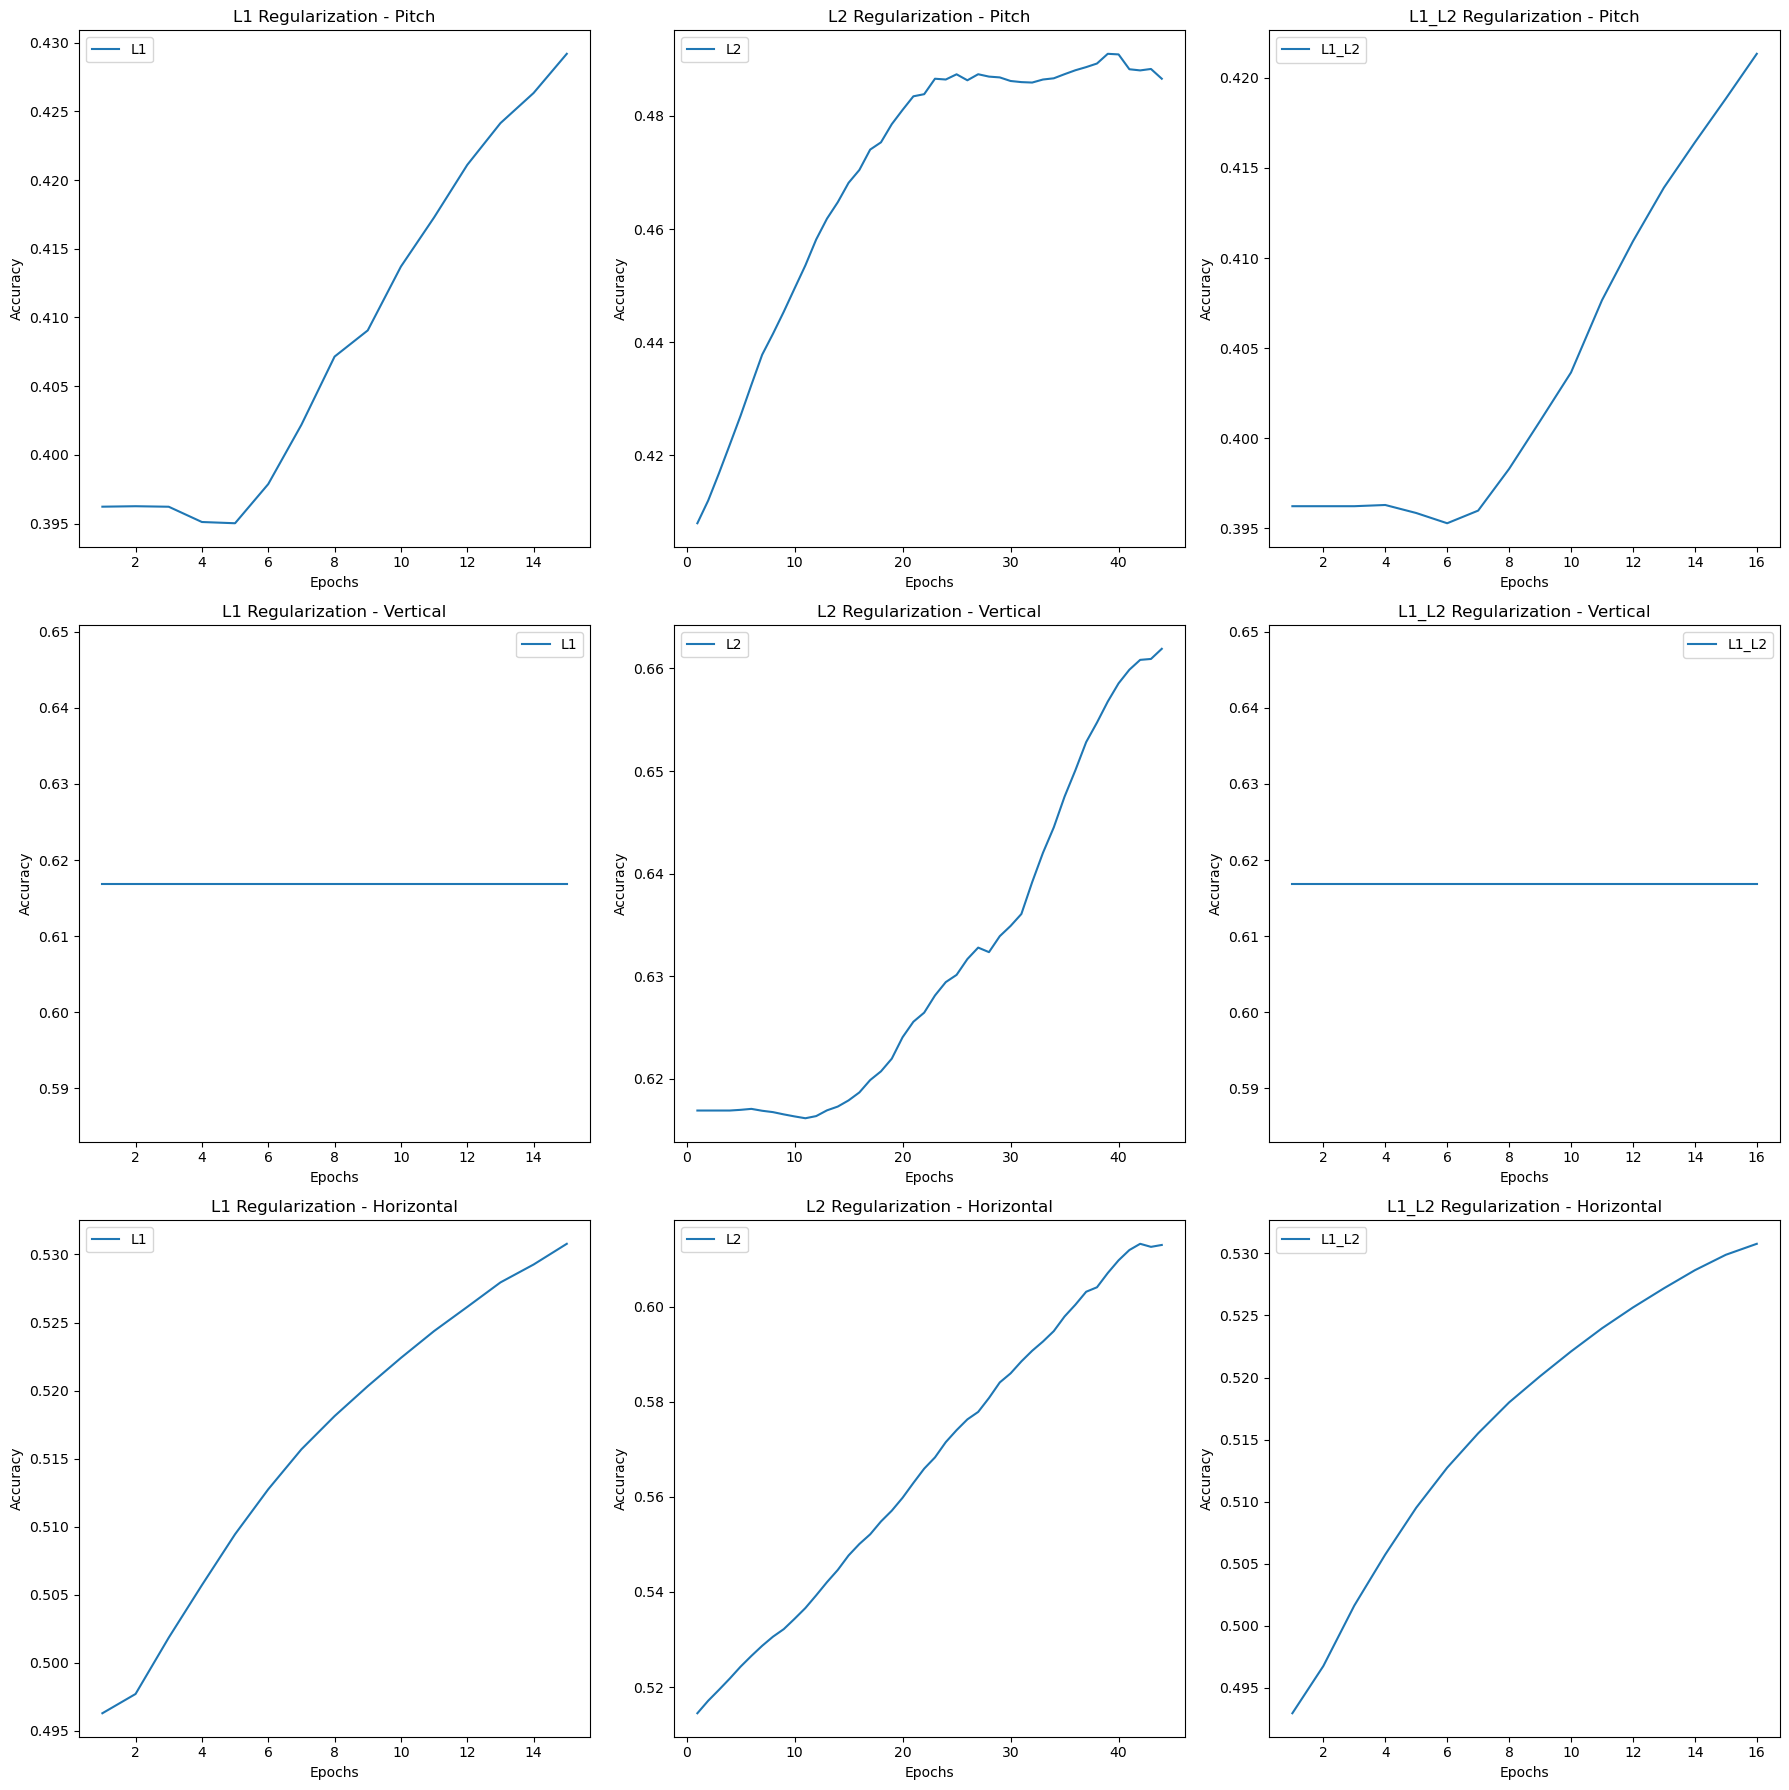

In [28]:
from utils.plot_utils import smooth_curve

import matplotlib.pyplot as plt

# Smooth the curves for better visualization
smooth_l1_pitch = smooth_curve(histories[0].history['val_pitch_output_accuracy'])
smooth_l2_pitch = smooth_curve(histories[1].history['val_pitch_output_accuracy'])
smooth_l1_l2_pitch = smooth_curve(histories[2].history['val_pitch_output_accuracy'])

smooth_l1_vertical = smooth_curve(histories[0].history['val_vertical_output_accuracy'])
smooth_l2_vertical = smooth_curve(histories[1].history['val_vertical_output_accuracy'])
smooth_l1_l2_vertical = smooth_curve(histories[2].history['val_vertical_output_accuracy'])

smooth_l1_horizontal = smooth_curve(histories[0].history['val_horizontal_output_accuracy'])
smooth_l2_horizontal = smooth_curve(histories[1].history['val_horizontal_output_accuracy'])
smooth_l1_l2_horizontal = smooth_curve(histories[2].history['val_horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot L1 regularization
axes[0, 0].plot(range(1, len(smooth_l1_pitch) + 1), smooth_l1_pitch, label='L1')
axes[0, 0].set_title('L1 Regularization - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

axes[1, 0].plot(range(1, len(smooth_l1_vertical) + 1), smooth_l1_vertical, label='L1')
axes[1, 0].set_title('L1 Regularization - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

axes[2, 0].plot(range(1, len(smooth_l1_horizontal) + 1), smooth_l1_horizontal, label='L1')
axes[2, 0].set_title('L1 Regularization - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot L2 regularization
axes[0, 1].plot(range(1, len(smooth_l2_pitch) + 1), smooth_l2_pitch, label='L2')
axes[0, 1].set_title('L2 Regularization - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 1].plot(range(1, len(smooth_l2_vertical) + 1), smooth_l2_vertical, label='L2')
axes[1, 1].set_title('L2 Regularization - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

axes[2, 1].plot(range(1, len(smooth_l2_horizontal) + 1), smooth_l2_horizontal, label='L2')
axes[2, 1].set_title('L2 Regularization - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

# Plot L1_L2 regularization
axes[0, 2].plot(range(1, len(smooth_l1_l2_pitch) + 1), smooth_l1_l2_pitch, label='L1_L2')
axes[0, 2].set_title('L1_L2 Regularization - Pitch')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()

axes[1, 2].plot(range(1, len(smooth_l1_l2_vertical) + 1), smooth_l1_l2_vertical, label='L1_L2')
axes[1, 2].set_title('L1_L2 Regularization - Vertical')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].legend()

axes[2, 2].plot(range(1, len(smooth_l1_l2_horizontal) + 1), smooth_l1_l2_horizontal, label='L1_L2')
axes[2, 2].set_title('L1_L2 Regularization - Horizontal')
axes[2, 2].set_xlabel('Epochs')
axes[2, 2].set_ylabel('Accuracy')
axes[2, 2].legend()

plt.tight_layout()
plt.show()

After comparing the results, we can see that the model with L1 regularization avoided the accuracy drop in the pitch type network. All models have similar performance, but L1 regularization is the best choice for avoiding overfitting. L2 regularization provided a better validation accuracy, but had a considerable drop after 40 epochs.

### Dropout

In [29]:
def build_model(drop):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=3,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='tanh',
                         dropout=drop)
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid',
                         dropout=drop)
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid',
                         dropout=drop)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [30]:
dropout_rates = [0, 0.5]
histories_dropout = []

for dropout_rate in dropout_rates:
    print("Testing with dropout rate:", dropout_rate)
    model = build_model(drop=dropout_rate)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories_dropout.append(history)

Testing with dropout rate: 0

Freezing output vertical at 6 epochs.

Freezing output pitch at 23 epochs.

Freezing output horizontal at 33 epochs.

All outputs frozen. Stopping training at epoch 33.
Testing with dropout rate: 0.5

Freezing output horizontal at 27 epochs.

Freezing output pitch at 28 epochs.

Freezing output vertical at 34 epochs.

All outputs frozen. Stopping training at epoch 34.


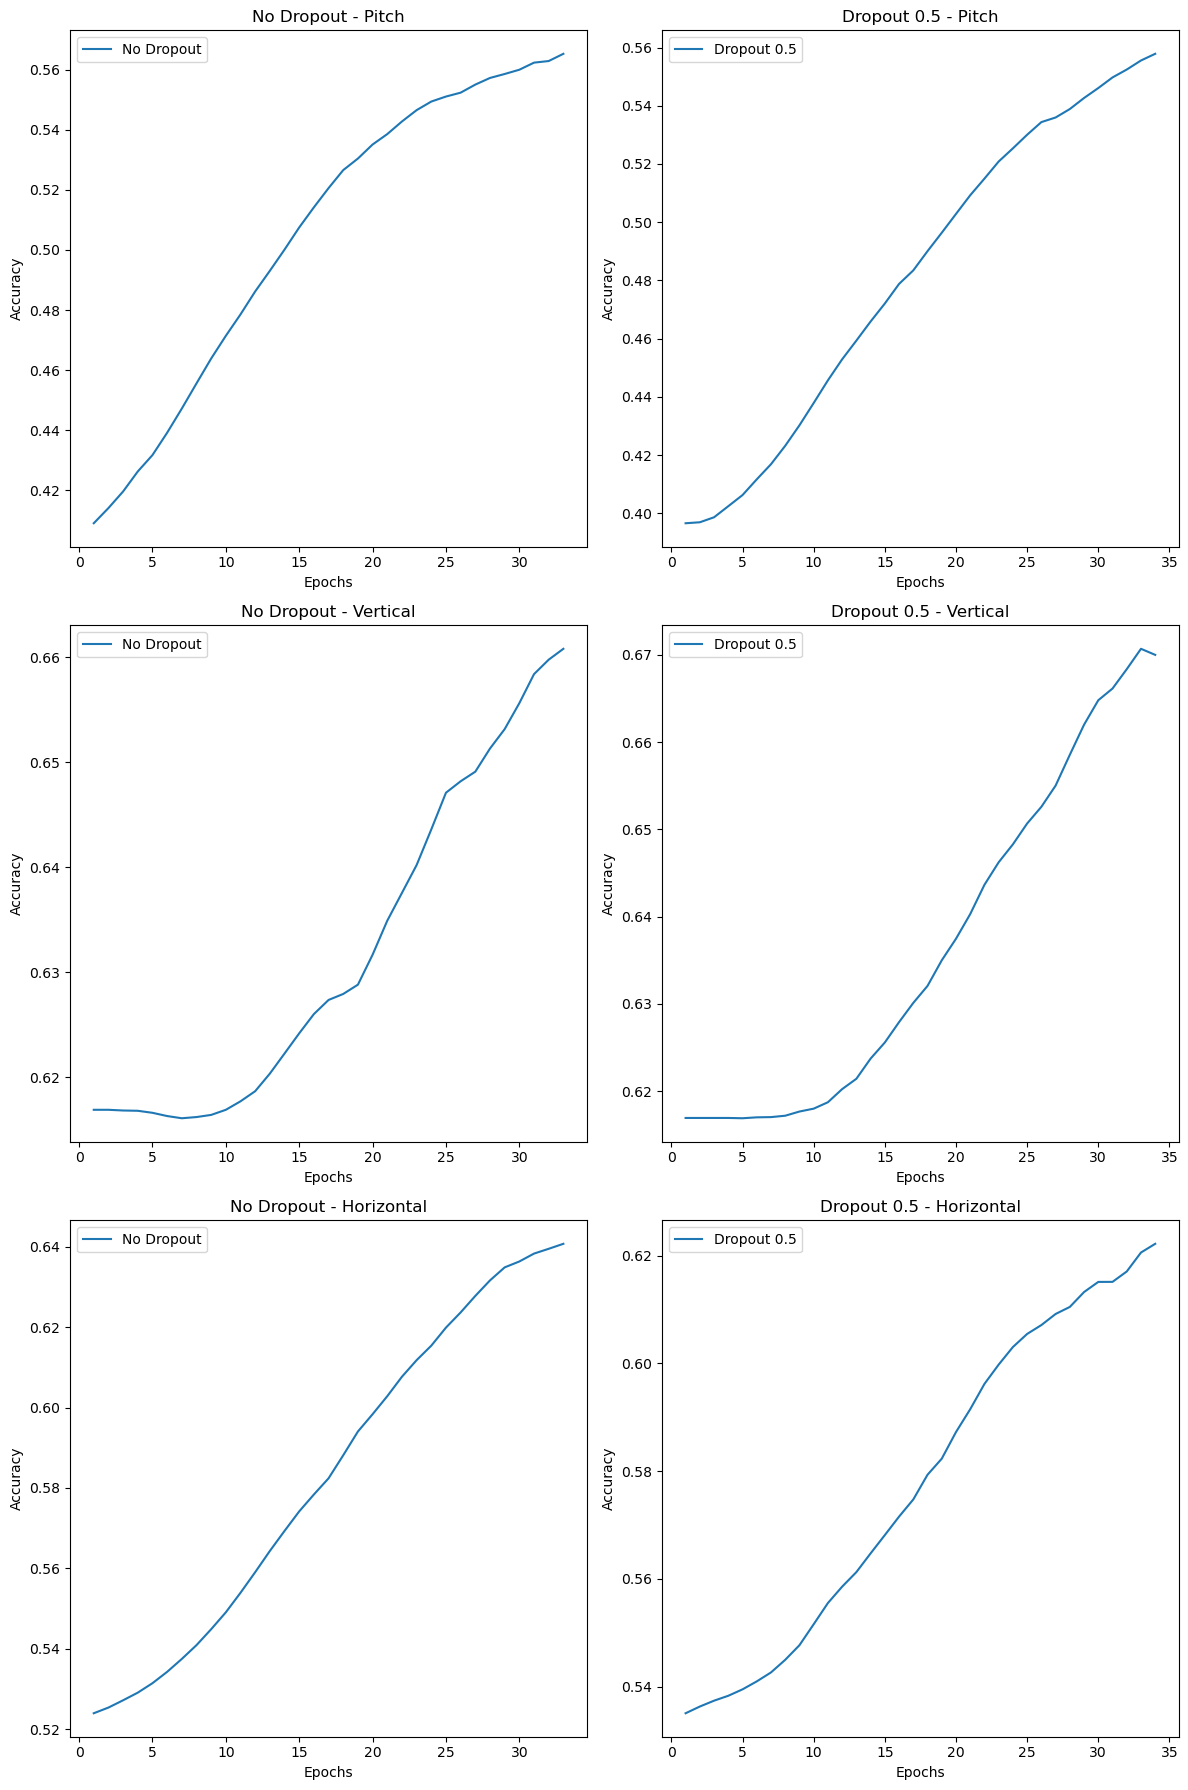

In [32]:
# Smooth the curves for better visualization
smooth_no_drop_pitch = smooth_curve(histories_dropout[0].history['val_pitch_output_accuracy'])
smooth_drop_05_pitch = smooth_curve(histories_dropout[1].history['val_pitch_output_accuracy'])

smooth_no_drop_vertical = smooth_curve(histories_dropout[0].history['val_vertical_output_accuracy'])
smooth_drop_05_vertical = smooth_curve(histories_dropout[1].history['val_vertical_output_accuracy'])

smooth_no_drop_horizontal = smooth_curve(histories_dropout[0].history['val_horizontal_output_accuracy'])
smooth_drop_05_horizontal = smooth_curve(histories_dropout[1].history['val_horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Plot without dropout for pitch
axes[0, 0].plot(range(1, len(smooth_no_drop_pitch) + 1), smooth_no_drop_pitch, label='No Dropout')
axes[0, 0].set_title('No Dropout - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot with 0.5 dropout for pitch
axes[0, 1].plot(range(1, len(smooth_drop_05_pitch) + 1), smooth_drop_05_pitch, label='Dropout 0.5')
axes[0, 1].set_title('Dropout 0.5 - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot without dropout for vertical
axes[1, 0].plot(range(1, len(smooth_no_drop_vertical) + 1), smooth_no_drop_vertical, label='No Dropout')
axes[1, 0].set_title('No Dropout - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Plot with 0.5 dropout for vertical
axes[1, 1].plot(range(1, len(smooth_drop_05_vertical) + 1), smooth_drop_05_vertical, label='Dropout 0.5')
axes[1, 1].set_title('Dropout 0.5 - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Plot without dropout for horizontal
axes[2, 0].plot(range(1, len(smooth_no_drop_horizontal) + 1), smooth_no_drop_horizontal, label='No Dropout')
axes[2, 0].set_title('No Dropout - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot with 0.5 dropout for horizontal
axes[2, 1].plot(range(1, len(smooth_drop_05_horizontal) + 1), smooth_drop_05_horizontal, label='Dropout 0.5')
axes[2, 1].set_title('Dropout 0.5 - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


## Final Model

Regularization and dropout will be used for the pitch type network. The final model will be trained using the hyperparameters from Trial 04 for the location networks and Trial 01 for the pitch type network.

In [33]:
def build_model():
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=3,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='tanh')
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid')
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                         num_hidden_layers=1,
                         num_hidden_units=128,
                         activation='relu',
                         recurrent_activation='sigmoid')

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [34]:
# Test the build_model function
model = build_model()

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output vertical at 33 epochs.

Freezing output horizontal at 44 epochs.

Freezing output pitch at 45 epochs.

All outputs frozen. Stopping training at epoch 45.


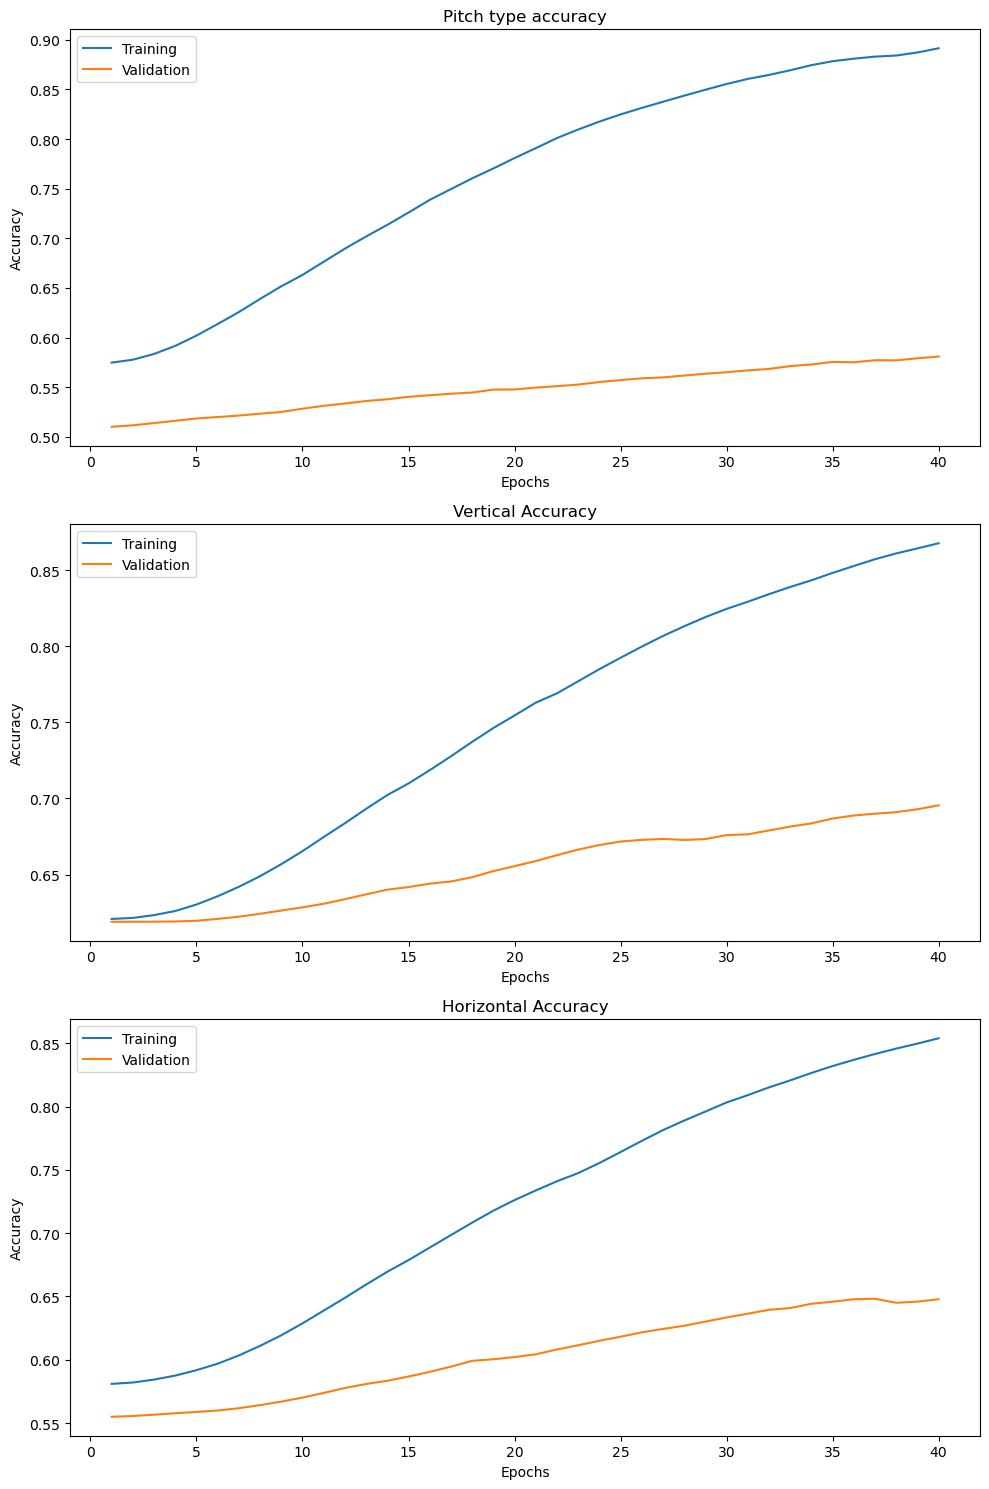

In [35]:
plot_ensemble_history(history)

In [36]:
max_pitch_val_accuracy = max(history.history['val_pitch_output_accuracy'])
max_vertical_val_accuracy = max(history.history['val_vertical_output_accuracy'])
max_horizontal_val_accuracy = max(history.history['val_horizontal_output_accuracy'])

print(f"Max Pitch Validation Accuracy: {max_pitch_val_accuracy}")
print(f"Max Vertical Validation Accuracy: {max_vertical_val_accuracy}")
print(f"Max Horizontal Validation Accuracy: {max_horizontal_val_accuracy}")

Max Pitch Validation Accuracy: 0.5983827710151672
Max Vertical Validation Accuracy: 0.7186657786369324
Max Horizontal Validation Accuracy: 0.6745283007621765


We can see a considerable increase in each output's accuracy compared to the baseline. Now, it is time to test the final model in the test set.

In [37]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - horizontal_output_accuracy: 0.6849 - loss: 5.3642 - pitch_output_accuracy: 0.6233 - vertical_output_accuracy: 0.7108
Pitch Test Accuracy: 0.6805930137634277
Vertical Test Accuracy: 0.6135444641113281
Horizontal Test Accuracy: 0.7169811129570007


We notice mixed results in the test set. Pitch type accuracy increased, but the vertical location accuracy decreased under the baseline. The horizontal location accuracy remained the similar.